In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.enums import STATE_TO_CENSUS_REGION

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]

matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

# Data Preparation and Preprocessing

## Read data from PUDL DB and create some features 

In [5]:
%%time

FRC_EIA923_DATA_COLS = [
    "plant_id_eia",
    "report_date",
    "energy_source_code",
    "fuel_cost_per_mmbtu",
    "fuel_received_units",
    "fuel_mmbtu_per_unit",
]

logger.info("Query PUDL DB and build some features.")
plant_states = pd.read_sql("SELECT plant_id_eia, state FROM plants_entity_eia", pudl_engine)
fuel_group_eiaepm = pd.read_sql("SELECT code AS energy_source_code, fuel_group_eiaepm FROM energy_sources_eia", pudl_engine)

frc = (
    pd.read_sql("fuel_receipts_costs_eia923", pudl_engine, columns=FRC_EIA923_DATA_COLS)
    .merge(plant_states, on="plant_id_eia", how="left", validate="many_to_one")
    # Fuel group also cleanly categorizes fuel units, making fuel_mmbtu_per_unit more sensible.
    .merge(fuel_group_eiaepm, on="energy_source_code", how="left", validate="many_to_one")
    .pipe(apply_pudl_dtypes, group="eia")
    .assign(
        # There's no such thing as a free MMBTU
        fuel_cost_per_mmbtu=lambda x: x.fuel_cost_per_mmbtu.replace(0.0, np.nan),
        # Numerical representation of elapsed time
        elapsed_days=lambda x: (x.report_date - x.report_date.min()).dt.days,
        # Categorical months, to capture cyclical seasonal variability
        report_month=lambda x: x.report_date.dt.month,
        # Larger geographic area more likely to have lots of records
        census_region=lambda x: x.state.map(STATE_TO_CENSUS_REGION),
        # Need the total MMBTU for weighting the importance of the record
        # May also be predictive -- small deliveries seem more likely to be expensive
        fuel_received_mmbtu=lambda x: x.fuel_received_units * x.fuel_mmbtu_per_unit,
    )
    .drop(columns=["report_date", "fuel_received_units"])
    .convert_dtypes(convert_floating=False)
)

# The HistGBR model and OrdinalEncoder are supposedly fine with NA values but...
string_cols = frc.select_dtypes("string").columns
frc.loc[:, string_cols] = frc[string_cols].fillna("NULL")

Query PUDL DB and build some features.
CPU times: user 3.19 s, sys: 200 ms, total: 3.39 s
Wall time: 3.46 s


In [6]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571400 entries, 0 to 571399
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   plant_id_eia         571400 non-null  Int64  
 1   energy_source_code   571400 non-null  string 
 2   fuel_cost_per_mmbtu  381423 non-null  float64
 3   fuel_mmbtu_per_unit  571400 non-null  float64
 4   state                571400 non-null  string 
 5   fuel_group_eiaepm    571400 non-null  string 
 6   elapsed_days         571400 non-null  Int64  
 7   report_month         571400 non-null  Int64  
 8   census_region        571400 non-null  string 
 9   fuel_received_mmbtu  571400 non-null  float64
dtypes: Int64(3), float64(3), string(4)
memory usage: 49.6 MB


## Split the data into different functional parts...

In [7]:
# Records where we're missing the target value:
frc_to_predict = frc[frc.fuel_cost_per_mmbtu.isna()]

# Records where we have the target value:
frc_train_test = frc[frc.fuel_cost_per_mmbtu.notna()]

# The data we're going to use to predict:
frc_data = frc_train_test.drop(columns=["fuel_cost_per_mmbtu"])

# The target we're trying to predict:
frc_target = frc_train_test["fuel_cost_per_mmbtu"]

# Relative importance of each of the records:
sample_weight=frc_data["fuel_received_mmbtu"]

## Build a Pipeline

In [8]:
cat_cols = [
#   "energy_source_code",
    "fuel_group_eiaepm",
    "state",
    "report_month",
#   "census_region",
]

num_cols = [
    "plant_id_eia", 
    "elapsed_days",
    "fuel_mmbtu_per_unit",
#   "fuel_received_mmbtu",
]

ord_enc = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="string"),
    ),
    remainder="passthrough",
)

pipe = Pipeline([
    ("ord_enc", ord_enc),
    ("hist_gbr", HistGradientBoostingRegressor(loss="absolute_error")),
])

## Set up Grid Search Cross Validation

In [9]:
%%time
gss = GroupShuffleSplit(test_size=0.2, n_splits=5, random_state=0)
# Split based on Plant ID to avoid plant information leaking between test / training
# This is mostly just an example. Not sure it's actually a good idea.
gss_split = gss.split(frc_train_test, groups=frc_train_test["plant_id_eia"])
param_grid = {
    "hist_gbr__max_depth": [3, 5, 7],
    "hist_gbr__max_leaf_nodes": [7, 15, 31],
    "hist_gbr__learning_rate": [0.1, 0.3, 0.9],
}

# Define hyperparameter space to search:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=gss_split, n_jobs=-1)

# Train up all the models and store the results.
# Weight samples by `sample_weight` during training.
result = grid.fit(
    X=frc_train_test[cat_cols+num_cols],
    y=frc_target,
    hist_gbr__sample_weight=sample_weight,
)

/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature 

CPU times: user 22.3 s, sys: 931 ms, total: 23.2 s
Wall time: 6min 50s


## Use the best estimator to predict missing fuel prices

In [10]:
%%time
predicted_fuel_costs = grid.best_estimator_.predict(X=frc_to_predict[cat_cols+num_cols])
frc_predicted = (
    frc_to_predict.copy()
    .drop(columns=["fuel_cost_per_mmbtu"])
    .assign(fuel_cost_per_mmbtu=predicted_fuel_costs)
)
frc_predicted

CPU times: user 2.09 s, sys: 15.7 ms, total: 2.11 s
Wall time: 734 ms


,plant_id_eia,energy_source_code,fuel_mmbtu_per_unit,state,fuel_group_eiaepm,elapsed_days,report_month,census_region,fuel_received_mmbtu,fuel_cost_per_mmbtu
154,228,NG,1.029,CA,natural_gas,0,1,PCC,185.220,7.940679
157,259,NG,1.020,CA,natural_gas,0,1,PCC,121225.980,8.174336
158,260,NG,1.020,CA,natural_gas,0,1,PCC,1186374.240,8.174336
159,260,NG,1.020,CA,natural_gas,0,1,PCC,3609207.780,8.174336
160,271,NG,1.026,CA,natural_gas,0,1,PCC,64.638,7.972022
...,...,...,...,...,...,...,...,...,...,...
571386,60903,NG,1.046,MA,natural_gas,4718,12,NEW,1322980.800,3.474161
571394,61028,NG,1.031,PA,natural_gas,4718,12,MAT,4343603.000,3.407660
571395,61035,NG,1.052,PA,natural_gas,4718,12,MAT,1907239.180,3.445659
571397,62115,NG,1.042,CA,natural_gas,4718,12,PCC,804976.260,4.183178


## Visualize the predicted prices by fuel group

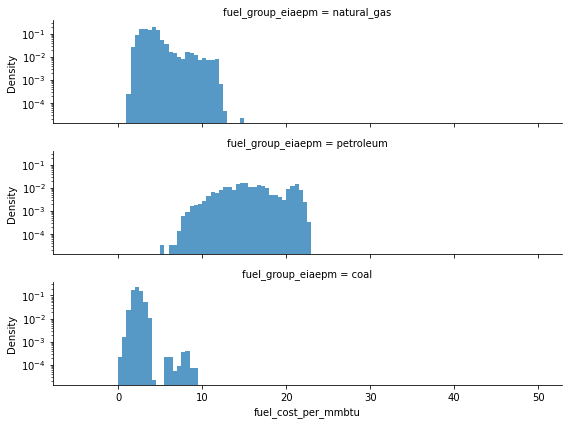

In [11]:
sns.displot(
    frc_predicted[frc_predicted.fuel_group_eiaepm.isin(["coal", "petroleum", "natural_gas"])],
    x="fuel_cost_per_mmbtu",
    row="fuel_group_eiaepm",
    bins=110,
    binrange=(-5,50),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    log=True,
);

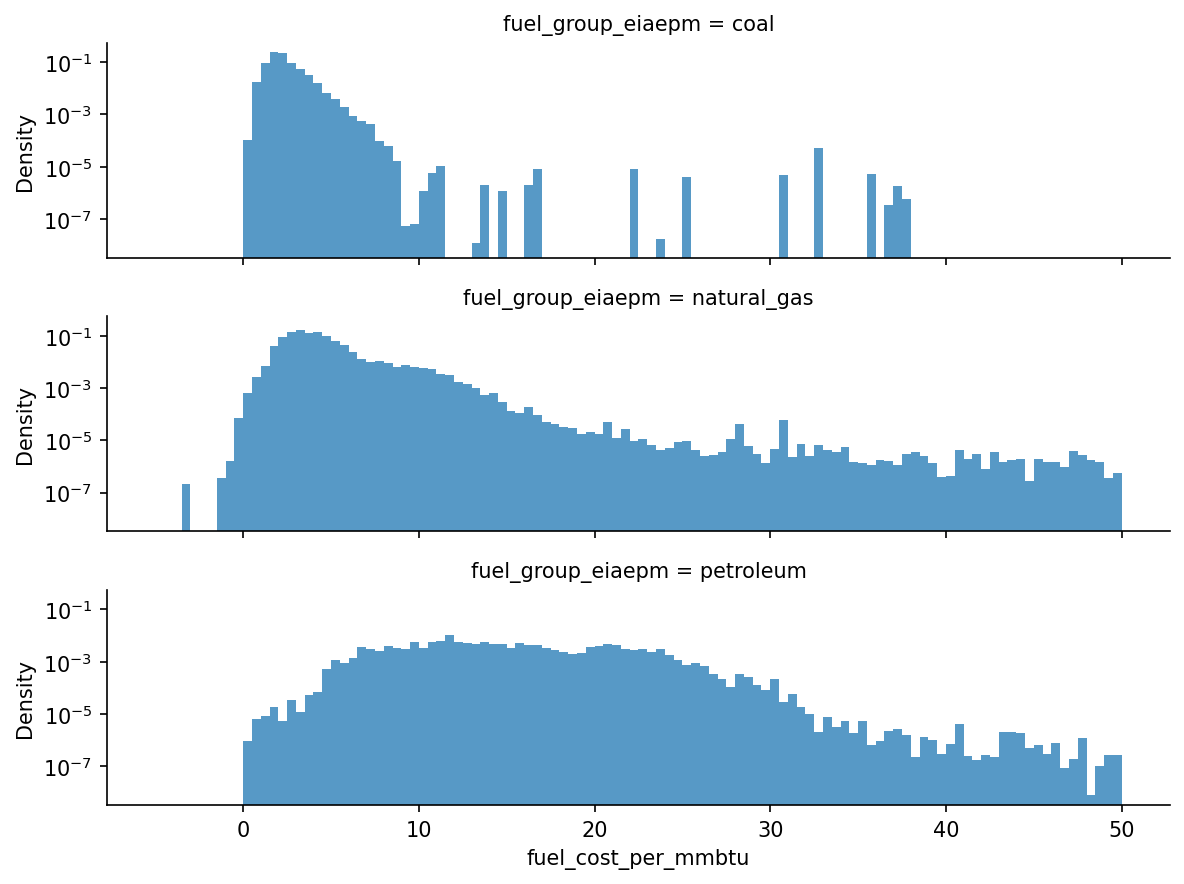

In [12]:
sns.displot(
    frc_train_test[frc_train_test.fuel_group_eiaepm.isin(["coal", "petroleum", "natural_gas"])],
    x="fuel_cost_per_mmbtu",
    row="fuel_group_eiaepm",
    bins=110,
    weights=frc_train_test[frc_train_test.fuel_group_eiaepm.isin(["coal", "petroleum", "natural_gas"])]["fuel_received_mmbtu"],
    binrange=(-5,50),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    log=True,
);

In [13]:
pd.DataFrame({
    x: result.cv_results_[x] for x in
    ["rank_test_score", "mean_test_score", "std_test_score"]
})

,rank_test_score,mean_test_score,std_test_score
0,22,-0.000061,0.000027
1,18,-0.000061,0.000027
2,23,-0.000061,0.000027
3,27,-0.000062,0.000027
4,14,-0.000060,0.000028
5,10,-0.000060,0.000028
6,25,-0.000062,0.000028
7,20,-0.000061,0.000027
8,16,-0.000060,0.000028
9,17,-0.000061,0.000027
